In [1]:
import numpy as np
import urllib.request
import gzip
import os
from sklearn.model_selection import train_test_split

In [2]:
import os
import urllib.request
import gzip
import numpy as np
from sklearn.model_selection import train_test_split

# Function to download and extract MNIST dataset
def download_mnist(filename, url):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

def load_mnist_images(filename):
    """
    Returns MNIST images as a 2D NumPy array of shape (num_samples, 784),
    scaled to [0, 1].
    """
    with gzip.open(filename, 'rb') as f:
        # Flatten the images (28x28 -> 784) and convert to float in [0, 1]
        return np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28) / 255.0

def load_mnist_labels(filename):
    """
    Returns one-hot encoded labels of shape (num_samples, 10).
    """
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
        # Convert to one-hot
        return np.eye(10)[labels]

# Updated URLs for MNIST dataset
base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
files = {
    "train_images": "train-images-idx3-ubyte.gz",
    "train_labels": "train-labels-idx1-ubyte.gz",
    "test_images":  "t10k-images-idx3-ubyte.gz",
    "test_labels":  "t10k-labels-idx1-ubyte.gz"
}

# Download files if not already present
for key, filename in files.items():
    download_mnist(filename, base_url + filename)

# Load the raw dataset
x_train_raw = load_mnist_images(files["train_images"])
y_train_raw = load_mnist_labels(files["train_labels"])
x_test_raw  = load_mnist_images(files["test_images"])
y_test_raw  = load_mnist_labels(files["test_labels"])

# Concatenate train and test sets (so we can do a new train/val/test split)
x_all = np.concatenate([x_train_raw, x_test_raw], axis=0)
y_all = np.concatenate([y_train_raw, y_test_raw], axis=0)

# Split into 70% train, 15% validation, 15% test
x_train, x_temp, y_train, y_temp = train_test_split(
    x_all, y_all, test_size=0.3, random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)



print("Shapes:")
print("  x_train:", x_train.shape, "  y_train:", y_train.shape)
print("  x_val:  ", x_val.shape,   "  y_val:  ", y_val.shape)
print("  x_test: ", x_test.shape,  "  y_test: ", y_test.shape)

print("\nData has been loaded, split, and standardized.\n")


Shapes:
  x_train: (49000, 784)   y_train: (49000, 10)
  x_val:   (10500, 784)   y_val:   (10500, 10)
  x_test:  (10500, 784)   y_test:  (10500, 10)

Data has been loaded, split, and standardized.



In [3]:
from mlp import *
from utils import *
from loss_functions import *

In [4]:
l = [x_train[0].shape[0], 128, 64,10]
layers = [
    Layer(l[0], l[1], ReLU(), dropout_rate=0.2),
    Layer(l[1], l[2], ReLU(), dropout_rate=0.2),
    Layer(l[2], l[3], Softmax())
]
model = MultilayerPerceptron(layers)
loss_fn = CrossEntropy()

In [5]:
training_loss, val_loss = model.train(
    x_train, 
    y_train, 
    x_val, 
    y_val, 
    loss_fn, 
    batch_size=4096, 
    epochs=50, 
    learning_rate=0.001,
    rmsprop=True
)

-------------------------------------
Epoch: 0, Train Loss: 17.940301599142668, Validation Loss: 2.2477177529858996
-------------------------------------
Epoch: 1, Train Loss: 9.011467462394819, Validation Loss: 1.4518892304278301
-------------------------------------
Epoch: 2, Train Loss: 6.791775305771851, Validation Loss: 1.1665888402970281
-------------------------------------
Epoch: 3, Train Loss: 5.6175629815361425, Validation Loss: 1.0108729302957353
-------------------------------------
Epoch: 4, Train Loss: 4.824994411043482, Validation Loss: 0.900295144596654
-------------------------------------
Epoch: 5, Train Loss: 4.314868235974498, Validation Loss: 0.7908911300624979
-------------------------------------
Epoch: 6, Train Loss: 3.8693510590818594, Validation Loss: 0.7401931546644949
-------------------------------------
Epoch: 7, Train Loss: 3.6355022235795658, Validation Loss: 0.6820018864952002
-------------------------------------
Epoch: 8, Train Loss: 3.291964636151307

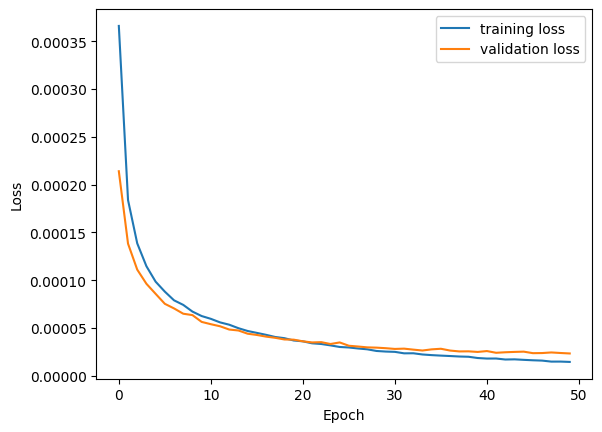

In [6]:
# plot training and validation loss
plt.plot(training_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
y_pred = model.forward(x_test)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
print("Test accuracy: ", accuracy)  

Test accuracy:  0.9635238095238096


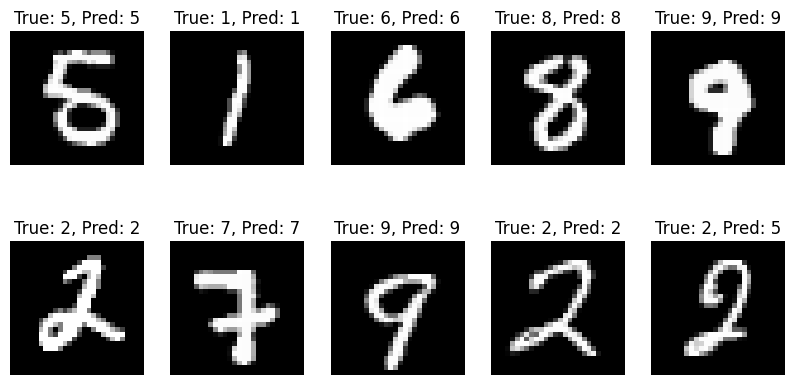

In [17]:
indices = np.random.choice(x_test.shape[0], 10)
x_sample = x_test[indices]
y_sample = y_test[indices]
y_pred = model.forward(x_sample)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_sample[i].reshape(28, 28), cmap='gray')
    plt.title("True: %d, Pred: %d" % (np.argmax(y_sample[i]), np.argmax(y_pred[i])))
    plt.axis('off')
plt.show()
